In [1]:
# 1-------------------------------
# Import necessary libraries
# -------------------------------
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import box_iou
from PIL import Image

# -------------------------------
# Set device (Kaggle P100 GPU)
# -------------------------------
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3080
Using device: cuda


In [2]:
# Utility: count classes from COCO and YOLO, and set num_classes
from pathlib import Path

def count_classes(dataset_root):
    ann_path = os.path.join(dataset_root, 'train', 'train_annotations.json')
    classes_from_coco = []
    if os.path.exists(ann_path):
        with open(ann_path, 'r', encoding='utf-8') as f:
            coco = json.load(f)
        classes_from_coco = [c.get('name', str(c.get('id'))) for c in coco.get('categories', [])]
    labels_dir = os.path.join(dataset_root, 'All labels with Pose information', 'labels')
    class_ids = set()
    if os.path.isdir(labels_dir):
        for p in Path(labels_dir).glob('*.txt'):
            for line in open(p, 'r', encoding='utf-8'):
                parts = line.strip().split()
                if parts:
                    try:
                        class_ids.add(int(parts[0]))
                    except Exception:
                        pass
    # Prefer COCO categories if present, else YOLO ids
    if classes_from_coco:
        cls_names = classes_from_coco
        n_no_bg = len(classes_from_coco)
    else:
        cls_names = [f'class_{i}' for i in sorted(class_ids)]
        n_no_bg = len(class_ids)
    n_with_bg = n_no_bg + 1  # add background for Faster R-CNN
    print('COCO categories:', cls_names)
    print('num_classes (without background):', n_no_bg)
    print('Faster R-CNN num_classes (with background):', n_with_bg)
    return cls_names, n_no_bg, n_with_bg

DATASET_ROOT = './C2A_Dataset/new_dataset3'
CLASS_NAMES, NUM_CLASSES_NO_BG, NUM_CLASSES = count_classes(DATASET_ROOT)

COCO categories: ['0']
num_classes (without background): 1
Faster R-CNN num_classes (with background): 2


In [3]:
# 2-------------------------------
# Custom Dataset Class (using COCO annotations)
# -------------------------------

def load_yolo_annotations(yolo_label_path, img_width, img_height):
    """
    Load YOLO-format annotations with pose information from a text file.
    
    Each line in the file has 6 values:
      - class: (ignored, because we are forcing a single "person" label)
      - x_center: normalized center x-coordinate of the bounding box
      - y_center: normalized center y-coordinate of the bounding box
      - width: normalized width of the bounding box
      - height: normalized height of the bounding box
      - pose: pose information (ignored in this version since we force the label to 1)
      
    The normalized coordinates are multiplied by the image width/height
    to convert them into absolute pixel values.
    
    The YOLO format defines bounding boxes with a center and dimensions.
    This function converts that format to the [x_min, y_min, x_max, y_max] format 
    required by Faster R-CNN.
    
    Returns:
       - boxes: a tensor of shape (N, 4) containing bounding boxes in absolute pixel coordinates.
       - labels: a tensor of shape (N,) containing the forced label (1) for "person".
    """
    
    # Check if the annotation file exists; if not, list available files for debugging.
    if not os.path.exists(yolo_label_path):
        available = os.listdir(os.path.dirname(yolo_label_path))
        raise FileNotFoundError(f"File not found: {yolo_label_path}\nAvailable files: {available}")

    boxes = []   # List to hold bounding box coordinates
    labels = []  # List to hold labels for each bounding box
    with open(yolo_label_path, 'r') as f:
        # Read each line in the YOLO annotation file.
        for line in f.readlines():
            # Split the line into separate values (as strings)
            values = line.strip().split()
            # Ensure that there are at least 6 values; if not, skip this line.
            if len(values) < 6:
                continue  # Skip invalid lines

            # Convert the relevant values from string to float:
            # Skip the first value (class) because we force the label later.
            # Extract normalized values
            x_center_norm, y_center_norm, width_norm, height_norm = map(float, values[1:5])

            # Convert normalized coordinates to absolute pixel values
            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            width_abs = width_norm * img_width
            height_abs = height_norm * img_height
            
            # Convert YOLO bounding box format (center, width, height) to
            # [x_min, y_min, x_max, y_max] format.
            # Convert YOLO bbox (center, width, height) to [x_min, y_min, x_max, y_max]
            x_min = x_center - (width_abs / 2)
            y_min = y_center - (height_abs / 2)
            x_max = x_center + (width_abs / 2)
            y_max = y_center + (height_abs / 2)

            # Append the converted bounding box to the list.
            boxes.append([x_min, y_min, x_max, y_max])

            # Assign label 1 for "person" (single-class human detection)
            person_label = 1
            labels.append(person_label)

    # Convert the lists of boxes and labels into torch tensors.
    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

class C2ACocoDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Path to the new_dataset3 directory.
            split (str): 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir  # Root directory of the dataset
        self.split = split  # Dataset split (train/val/test)
        self.transform = transform  # Image transformations (e.g., normalization)

        # Image directory and COCO annotation JSON for the given split.
        # Define the image directory based on the split.
        self.img_dir = os.path.join(root_dir, split, "images")
        # Define the path to the COCO annotation JSON file for this split.
        self.ann_path = os.path.join(root_dir, split, f"{split}_annotations.json")

        # Load COCO JSON annotations.
        with open(self.ann_path, 'r') as f:
            self.coco_data = json.load(f)

        # Build mapping from image id to image info. (e.g., dimensions, filename).
        self.imgs = {img_info['id']: img_info for img_info in self.coco_data['images']}
        # Create a list of image IDs for indexing.
        self.ids = list(self.imgs.keys())

        # Define the folder that contains the YOLO-format labels with pose information.
        # This folder is inside the "All labels with Pose information" folder.
        self.pose_labels_dir = os.path.join(root_dir, "All labels with Pose information", "labels")

    def __len__(self):
        # Return the number of images in the dataset.
        return len(self.ids)

    def __getitem__(self, idx):
        """
        Retrieve a single image and its annotations.
        """
        # Retrieve image info.
        # Get the image ID from the list of IDs.
        img_id = self.ids[idx]
        # Retrieve the image information (dimensions, filename, etc.) using the image ID.
        img_info = self.imgs[img_id]
        # Extract the filename of the image.
        img_filename = img_info['file_name']
        # Build the full path to the image file.
        img_path = os.path.join(self.img_dir, img_filename)

        # Open the image using PIL and convert it to RGB format.
        image = Image.open(img_path).convert("RGB")
        # Apply transformations (e.g., ToTensor, normalization) if provided.
        if self.transform:
            image = self.transform(image)

        # Get image dimensions from COCO JSON.
        img_width = img_info['width']
        img_height = img_info['height']

        # Construct the path to the corresponding YOLO-format label file.
        # The label file has the same base filename as the image, but with a .txt extension.
        pose_label_path = os.path.join(self.pose_labels_dir, os.path.splitext(img_filename)[0] + ".txt")

        # Load YOLO annotations (with pose info) and convert to absolute coordinates.
        boxes, labels = load_yolo_annotations(pose_label_path, img_width, img_height)

        # Build the target dictionary expected by the detection model.
        target = {
            "boxes": boxes,             # Bounding boxes in [x_min, y_min, x_max, y_max] format.
            "labels": labels,           # Labels for each bounding box (forced to 1 for person).
            "image_id": torch.tensor([img_id])  # Unique image identifier.
        }
        return image, target

In [6]:
# Augmentations: on-the-fly with bbox-aware affine and HSV
import albumentations as A
import cv2

# YOLO-style augmentation params mapped to Albumentations
# hsv_h:0.015, hsv_s:0.7, hsv_v:0.4 ~ Albumentations HueSaturationValue
train_tf = A.Compose([
    A.HueSaturationValue(hue_shift_limit=int(0.015*360), sat_shift_limit=int(0.7*255), val_shift_limit=int(0.4*255), p=0.9),
    A.HorizontalFlip(p=0.5),  # fliplr=0.5
    A.Affine(
        rotate=(15, 30),     # degrees 15–30
        translate_percent=(0.1, 0.1),
        scale=(1-0.5, 1+0.5),
        shear=(0.0, 0.0),
        fit_output=False,
        cval=(114, 114, 114),
        mode=cv2.BORDER_CONSTANT,
        p=0.9
    ),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], clip=True, min_visibility=0.0))

eval_tf = A.Compose([], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], clip=True))

# Wrap the existing dataset to add Albumentations
class AugmentedC2A(C2ACocoDataset):
    def __init__(self, *args, augment=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.augment = augment
    
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        # Convert PIL image to numpy
        img_np = np.array(image)
        boxes = target['boxes'].numpy().astype(np.float32)
        labels = target['labels'].numpy().astype(np.int64)
        H, W = img_np.shape[:2]
        # Albumentations expects list of bboxes + labels
        bboxes = boxes.tolist()
        class_labels = labels.tolist()
        tf = train_tf if self.augment else eval_tf
        if len(bboxes) > 0:
            transformed = tf(image=img_np, bboxes=bboxes, class_labels=class_labels)
        else:
            transformed = tf(image=img_np, bboxes=[], class_labels=[])
        img_aug = transformed['image']
        bboxes_aug = transformed.get('bboxes', [])
        labels_aug = transformed.get('class_labels', [])
        # Clamp bboxes to image bounds and filter invalid/tiny
        if len(bboxes_aug) > 0:
            b = np.asarray(bboxes_aug, dtype=np.float32)
            b[:,0] = np.clip(b[:,0], 0, img_aug.shape[1]-1)
            b[:,1] = np.clip(b[:,1], 0, img_aug.shape[0]-1)
            b[:,2] = np.clip(b[:,2], 0, img_aug.shape[1]-1)
            b[:,3] = np.clip(b[:,3], 0, img_aug.shape[0]-1)
            x1 = np.minimum(b[:,0], b[:,2]); y1 = np.minimum(b[:,1], b[:,3])
            x2 = np.maximum(b[:,0], b[:,2]); y2 = np.maximum(b[:,1], b[:,3])
            b = np.stack([x1,y1,x2,y2], axis=1)
            ws = (b[:,2]-b[:,0]); hs=(b[:,3]-b[:,1])
            keep = (ws>=2) & (hs>=2)
            b = b[keep]
            labels_aug = [l for l,k in zip(labels_aug, keep) if k]
        else:
            b = np.zeros((0,4), dtype=np.float32)
            labels_aug = []
        # Back to tensors
        image_t = transforms.ToTensor()(Image.fromarray(img_aug))
        target = {
            'boxes': torch.tensor(b, dtype=torch.float32),
            'labels': torch.tensor(labels_aug, dtype=torch.int64),
            'image_id': target['image_id']
        }
        return image_t, target

# Dataloaders with collate
collate_fn = lambda x: tuple(zip(*x))
train_dataset = AugmentedC2A(root_dir=dataset_root, split='train', transform=None, augment=True)
val_dataset   = AugmentedC2A(root_dir=dataset_root, split='val',   transform=None, augment=False)
test_dataset  = AugmentedC2A(root_dir=dataset_root, split='test',  transform=None, augment=False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

print('Rebuilt loaders with on-the-fly augmentations.')

C:\Users\PC\AppData\Local\Temp\ipykernel_41844\2264716417.py:10: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(


Rebuilt loaders with on-the-fly augmentations.


In [7]:
# 3-------------------------------
# Define image transforms: conversion to tensor and ImageNet normalization
# -------------------------------

# Compose a series of transformations to apply to each image:
# 1. Convert the image to a PyTorch tensor.
# 2. Normalize the image using the ImageNet mean and standard deviation.
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image (or numpy array) to a torch.Tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet mean values
                         std=[0.229, 0.224, 0.225])   # Normalize with ImageNet standard deviation values
])

# -------------------------------
# Set dataset root directory (update as needed in Kaggle)
# -------------------------------
dataset_root = './C2A_Dataset/new_dataset3'

# Create training and validation datasets and dataloaders.
from torch.utils.data import DataLoader

# This instance will load images and annotations from the 'train' split.
train_dataset = C2ACocoDataset(root_dir=dataset_root, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# train_subset = Subset(train_dataset, list(range(3000)))
# Create a DataLoader for the training subset with a batch size of 2, shuffling enabled,
# and a custom collate function that groups data samples into tuples.
# train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# This instance will load images and annotations from the 'val' split.
val_dataset = C2ACocoDataset(root_dir=dataset_root, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# val_subset = Subset(val_dataset, list(range(1000)))
# Create a DataLoader for the validation subset with a batch size of 1 (for easier evaluation)
# and no shuffling since order is not important during evaluation.
# val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# test subset if you're also using test set
test_dataset = C2ACocoDataset(root_dir=dataset_root, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# test_subset = Subset(test_dataset, list(range(1000)))
# Create a DataLoader for the test subset with a batch size of 1 and no shuffling.
# test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# -------------------------------
# Test the dataset loading by printing one sample's target
# -------------------------------
# Create an instance of the training dataset to test data loading.
dataset = C2ACocoDataset(root_dir=dataset_root, split="train", transform=transform)
# Retrieve the first sample (both image and its corresponding target annotations).
image, target = dataset[0]
# Print the target annotations to verify that the bounding boxes, labels, and image ID are loaded correctly.
print("Sample target:", target)

Sample target: {'boxes': tensor([[603.0001, 142.0000, 607.0001, 146.9999],
        [399.0004, 281.0002, 408.0002, 293.0002],
        [504.0002, 204.9997, 523.0004, 224.9998],
        [580.0000, 213.9999, 587.9999, 231.9997],
        [579.9997, 387.0002, 598.9999, 397.0000],
        [ 45.9999,  63.0002,  62.0002,  77.0000],
        [435.9998, 275.0001, 452.0001, 288.0001],
        [249.0000,  49.0001, 252.9999,  54.0000],
        [581.9997, 517.9998, 596.9999, 526.9997],
        [483.0003, 103.9998, 491.0002, 115.9999],
        [353.0002, 244.0003, 361.0000, 254.0001],
        [ 45.0002, 329.9998,  50.0001, 345.0000],
        [ 54.9997, 401.0001,  82.9997, 418.9999],
        [125.0003, 125.9999, 134.0001, 135.9997],
        [318.0003, 310.9998, 320.0003, 313.9999],
        [388.9997,  64.0001, 412.9998,  69.9999],
        [296.9998,  41.9997, 316.0001,  56.9999],
        [570.0002,  50.0000, 577.0001,  66.0001],
        [ 80.0001, 430.0001,  82.0000, 433.0002],
        [582.9999, 148.99

In [8]:
# 4-------------------------------
# Model Setup: Pretrained Faster R-CNN (MS COCO) + custom predictor
# -------------------------------
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# Load MS COCO pretrained weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # MS COCO
model = fasterrcnn_resnet50_fpn(weights=weights)

# Replace the classifier head for our dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Move to device
model.to(device)

print("Loaded pretrained Faster R-CNN (MS COCO) and replaced predictor to num_classes=", NUM_CLASSES)

Loaded pretrained Faster R-CNN (MS COCO) and replaced predictor to num_classes= 2


In [10]:
# 5-------------------------------
# Training Loop
# -------------------------------

# Set up optimizer, LR scheduler, and early stopping parameters

# Set up the optimizer: using SGD with momentum and weight decay for regularization.
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.0005)
# Set up the learning rate scheduler:
# This scheduler reduces the learning rate when the validation loss plateaus.
# lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1)
# Learning rate scheduler: Step decay instead of ReduceLROnPlateau
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
# Define the maximum number of training epochs.
num_epochs = 2  # Maximum epochs
# Initialize the best validation loss to a very high value for comparison.
best_val_loss = float('inf')
# Set the patience for early stopping (number of epochs with no improvement before stopping).
patience = 2
epochs_no_improve = 0

# Define a function to compute the validation loss.
# The model must be in training mode to return a loss dictionary.
def compute_val_loss(model, data_loader, device):
    model.train()  # Switch model to training mode so that it returns losses.
    total_loss = 0.0  # Initialize total loss accumulator.
    count = 0       # Count the number of batches.
    with torch.no_grad():  # Disable gradient computation for evaluation.
        for images, targets in data_loader:
            # Move images and targets to the designated device (GPU/CPU).
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass: obtain the loss dictionary from the model.
            loss_dict = model(images, targets)
            
            # Verify that loss_dict is indeed a dictionary and sum its values.
            if isinstance(loss_dict, dict):
                loss = sum(loss for loss in loss_dict.values())
            else:
                raise TypeError("Expected loss_dict to be a dictionary.")
            
            # Accumulate the loss and increment the batch counter.
            total_loss += loss.item()
            count += 1
    model.eval()  # Switch back to evaluation mode.
    # Return the average loss over the batches.
    return total_loss / count if count > 0 else 0

# Training loop (losses are hidden during training)
model.train()

# Loop over the number of epochs.
for epoch in range(num_epochs):
    # Iterate through each batch in the training DataLoader.
    for images, targets in train_loader:
        # Move images to the specified device.
        images = [img.to(device) for img in images]
        # Move all target tensors to the device.
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        model.train()  # Ensure the model is in training mode to compute losses.
        # Forward pass: compute the losses from the model for this batch.
        loss_dict = model(images, targets)
        
        # Ensure that the loss is in the expected dictionary format.
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:
            raise TypeError("Expected loss_dict to be a dictionary.")

        # Check for NaN losses and skip gradient update if necessary
        if torch.isnan(losses):
            print("Warning: NaN loss detected, skipping this batch!")
            continue  # Skip this batch to prevent model corruption
        
        # Zero out the gradients from the previous iteration.
        optimizer.zero_grad()
        # Backward pass: compute the gradients.
        losses.backward()
        # Gradient Clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        # Update the model's weights.
        optimizer.step()
    
    # After processing all batches in the current epoch, compute the validation loss.
    val_loss = compute_val_loss(model, val_loader, device)
    
    # Update the learning rate scheduler based on the validation loss.
    lr_scheduler.step(val_loss)
    
    # Print the validation loss for this epoch.
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
    
    # Early stopping check:
    # If the validation loss has improved, reset the counter; otherwise, increment it.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        # If no improvement has occurred for 'patience' epochs, stop training.
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Validation Loss: 0.9641
Epoch 2, Validation Loss: 0.9624
Epoch 2, Validation Loss: 0.9624


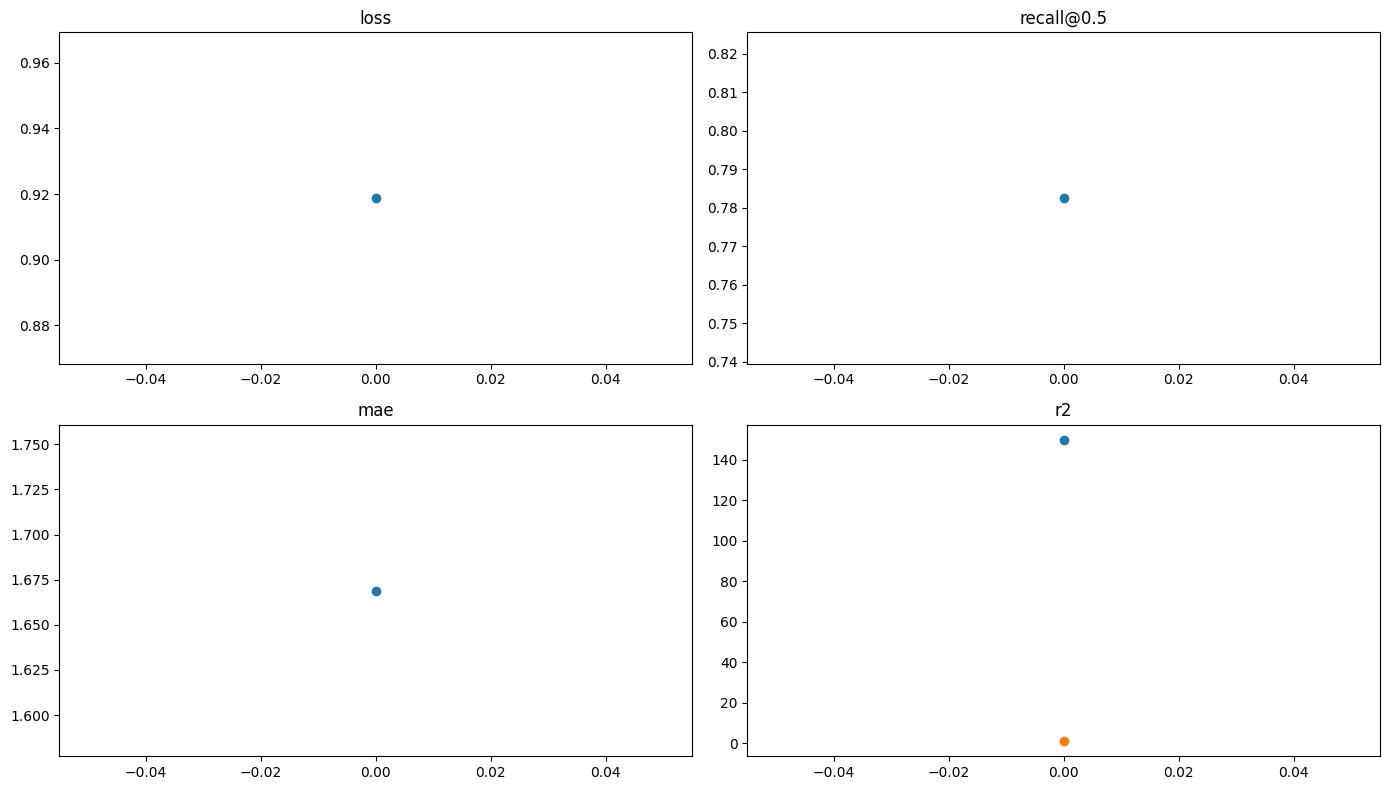

In [11]:
# Training with metrics logging and plots (Loss, Recall@0.5, MAE, MSE, R2)
from collections import defaultdict

def recall_at_iou(pred_boxes, gt_boxes, iou_thr=0.5):
    if len(gt_boxes)==0: return 1.0
    if len(pred_boxes)==0: return 0.0
    ious = box_iou(pred_boxes, gt_boxes)
    used = set(); tp=0
    for i in range(len(pred_boxes)):
        if ious.shape[1]==0: break
        v, j = ious[i].max(0)
        if v>=iou_thr and j.item() not in used:
            used.add(j.item()); tp+=1
    return tp/len(gt_boxes)

def bbox_regression_metrics(pred_boxes, gt_boxes):
    # simple center error metrics
    if len(gt_boxes)==0 or len(pred_boxes)==0:
        return 0.0, 0.0, 0.0
    ious = box_iou(pred_boxes, gt_boxes)
    matched = []
    used=set()
    for i in range(len(pred_boxes)):
        if ious.shape[1]==0: break
        v, j = ious[i].max(0)
        if j.item() not in used:
            used.add(j.item()); matched.append((pred_boxes[i], gt_boxes[j]))
    if not matched:
        return 0.0, 0.0, 0.0
    diffs=[]; gt_vals=[]
    for p,g in matched:
        pc = (p[:2]+p[2:])/2
        gc = (g[:2]+g[2:])/2
        diffs.append(((pc-gc)**2).mean())
        gt_vals.append(((gc)**2).mean())
    diffs = torch.tensor(diffs)
    mae = torch.sqrt(diffs).mean().item()
    mse = diffs.mean().item()
    r2 = 1 - (diffs.sum()/(torch.tensor(gt_vals).sum()+1e-6)).item()
    return mae, mse, r2

history = defaultdict(list)

optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=5e-4)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running=0.0; n=0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running += loss.item(); n+=1
        if n>=200: break
    history['loss'].append(running/max(n,1))

    # Eval quick
    model.eval(); recs=[]; maes=[]; mses=[]; r2s=[]
    with torch.no_grad():
        k=0
        for images, targets in val_loader:
            image = images[0].to(device)
            t = {k:v.to(device) for k,v in targets[0].items()}
            out = model([image])[0]
            keep = out['scores']>0.3
            pred_boxes = out['boxes'][keep]
            gt_boxes = t['boxes']
            recs.append(recall_at_iou(pred_boxes, gt_boxes, 0.5))
            mae, mse, r2 = bbox_regression_metrics(pred_boxes, gt_boxes)
            maes.append(mae); mses.append(mse); r2s.append(r2)
            k+=1
            if k>=100: break
    history['recall@0.5'].append(float(np.mean(recs) if recs else 0.0))
    history['mae'].append(float(np.mean(maes) if maes else 0.0))
    history['mse'].append(float(np.mean(mses) if mses else 0.0))
    history['r2'].append(float(np.mean(r2s) if r2s else 0.0))

# Plot history
def plot_hist(hist):
    keys = list(hist.keys())
    plt.figure(figsize=(14,8))
    for i,k in enumerate(keys,1):
        plt.subplot(2,2,i if i<=4 else 4)
        plt.plot(hist[k], marker='o')
        plt.title(k)
    plt.tight_layout(); plt.show()

plot_hist(history)

In [12]:
# 6-------------------------------
# Evaluation Function
# -------------------------------
def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.1):
    """
    Evaluate the detection model using several metrics.
    
    This function calculates:
    - Precision: Proportion of predicted boxes that are correct.
    - Recall: Proportion of ground truth boxes that were detected.
    - F1 Score: Harmonic mean of precision and recall.
    - Average IoU: Average Intersection over Union of matched predictions.
    - mAP: Mean Average Precision over multiple IoU thresholds (0.5 to 0.95).
    - mAP@0.50: Average Precision at a fixed IoU threshold of 0.50.
    
    By default, the score_threshold is lowered to 0.1 to allow more low-confidence boxes to be considered,
    which can help if the custom model produces lower scores than expected.
    
    Args:
        model: The detection model.
        data_loader: DataLoader for the dataset to evaluate.
        device: The device (GPU/CPU) to run evaluation on.
        iou_threshold: The IoU threshold for considering a prediction as a true positive.
        score_threshold: The score threshold for filtering predictions.
    
    Returns:
        Tuple with (precision, recall, f1_score, avg_iou, mAP, mAP_50)
    """
    model.eval()  # Set model to evaluation mode (disables dropout and updates batch norm stats)
    
    # Initialize accumulators for overall true positives, false positives, false negatives, and IoU.
    total_tp, total_fp, total_fn = 0, 0, 0
    total_iou = 0.0
    matched_boxes = 0  # Count of matched bounding boxes (true positives)
    
    # List to store the computed AP (Average Precision) for a range of IoU thresholds.
    aps = []
    # Define IoU thresholds ranging from 0.5 to 0.95 (in 0.05 increments)
    iou_thresholds = [0.5 + i * 0.05 for i in range(10)]
    
    # Disable gradient computations since we are evaluating.
    with torch.no_grad():
        # Loop over the data loader (assuming each batch contains one image)
        for images, targets in data_loader:
            # Move the image to the device.
            image = images[0].to(device)
            # Move target annotations (e.g., bounding boxes and labels) to the device.
            target = {k: v.to(device) for k, v in targets[0].items()}
            
            # Run a forward pass on the model for the given image.
            # During inference, we only pass the image (without target) to obtain predictions.
            outputs = model([image])[0]
            
            # Filter predictions using the score threshold.
            # Lowering score_threshold from 0.5 (default) to 0.1 allows more predictions to be considered.
            pred_boxes = outputs['boxes'][outputs['scores'] > score_threshold]
            # Ground truth bounding boxes for the image.
            gt_boxes = target['boxes']
            
            # If no predictions pass the threshold, treat all ground truth boxes as false negatives.
            if len(pred_boxes) == 0:
                total_fn += len(gt_boxes)
                continue
            
            # Compute Intersection-over-Union (IoU) between each predicted box and the ground truth boxes.
            ious = box_iou(pred_boxes, gt_boxes)
            used_gt = set()  # To mark which ground truth boxes have already been matched
            
            # Iterate over each predicted bounding box.
            for i in range(len(pred_boxes)):
                # If no ground truth boxes exist, skip.
                if ious.shape[1] == 0:
                    continue
                # For the i-th prediction, get the maximum IoU value and the corresponding ground truth index.
                max_iou, max_idx = ious[i].max(0)
                # Check if the maximum IoU meets the specified iou_threshold and that the matching gt hasn't been used.
                if max_iou >= iou_threshold and max_idx.item() not in used_gt:
                    total_tp += 1  # Count as a true positive.
                    total_iou += max_iou.item()  # Accumulate IoU for averaging later.
                    matched_boxes += 1  # Count the matched box.
                    used_gt.add(max_idx.item())  # Mark this ground truth box as used.
                else:
                    total_fp += 1  # If not, count as a false positive.
            # Any remaining ground truth boxes that were not matched are false negatives.
            total_fn += len(gt_boxes) - len(used_gt)
            
            # Now, compute a simplified Average Precision (AP) at multiple IoU thresholds.
            for threshold in iou_thresholds:
                tp, fp, fn = 0, 0, len(gt_boxes)
                matched_gt = set()
                # Evaluate each prediction at the current IoU threshold.
                for i in range(len(pred_boxes)):
                    if ious.shape[1] == 0:
                        continue
                    max_iou, max_idx = ious[i].max(0)
                    if max_iou >= threshold and max_idx.item() not in matched_gt:
                        tp += 1  # True Positive for this threshold.
                        matched_gt.add(max_idx.item())
                    else:
                        fp += 1  # False Positive for this threshold.
                fn -= len(matched_gt)
                precision_thresh = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall_thresh = tp / (tp + fn) if (tp + fn) > 0 else 0
                ap = precision_thresh * recall_thresh  # A simplified estimation of AP.
                aps.append(ap)
    
    # Calculate overall metrics across all images in the dataset.
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou = total_iou / matched_boxes if matched_boxes > 0 else 0
    
    # Compute mean Average Precision (mAP) as the average of the AP values across all IoU thresholds.
    mAP = sum(aps) / len(aps) if aps else 0  
    # mAP@0.5 is the AP at IoU threshold 0.5 (first value in the iou_thresholds list).
    mAP_50 = aps[0] if aps else 0  
    
    # Print the computed evaluation metrics.
    print("Testing Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1_score:.4f}")
    print(f"Avg IoU:   {avg_iou:.4f}")
    print(f"mAP:       {mAP:.4f}")
    print(f"mAP@.50:   {mAP_50:.4f}")
    
    # Return all metrics for further use if needed.
    return precision, recall, f1_score, avg_iou, mAP, mAP_50

# -------------------------------
# Compute evaluation metrics on the validation set.
# -------------------------------
print("Testing Metrics on the validation set:")
precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, val_loader, device, score_threshold=0.1)

# -------------------------------
# Evaluate on the test set now instead of the validation set.
# -------------------------------
print("Testing Metrics on the test set:")
precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, test_loader, device, score_threshold=0.1)


Testing Metrics on the validation set:
Testing Metrics:
Precision: 0.5526
Recall:    0.7874
F1 Score:  0.6495
Avg IoU:   0.7770
mAP:       0.2246
mAP@.50:   0.2942
Testing Metrics on the test set:
Testing Metrics:
Precision: 0.5526
Recall:    0.7874
F1 Score:  0.6495
Avg IoU:   0.7770
mAP:       0.2246
mAP@.50:   0.2942
Testing Metrics on the test set:
Testing Metrics:
Precision: 0.5570
Recall:    0.7925
F1 Score:  0.6542
Avg IoU:   0.7787
mAP:       0.2281
mAP@.50:   0.6441
Testing Metrics:
Precision: 0.5570
Recall:    0.7925
F1 Score:  0.6542
Avg IoU:   0.7787
mAP:       0.2281
mAP@.50:   0.6441


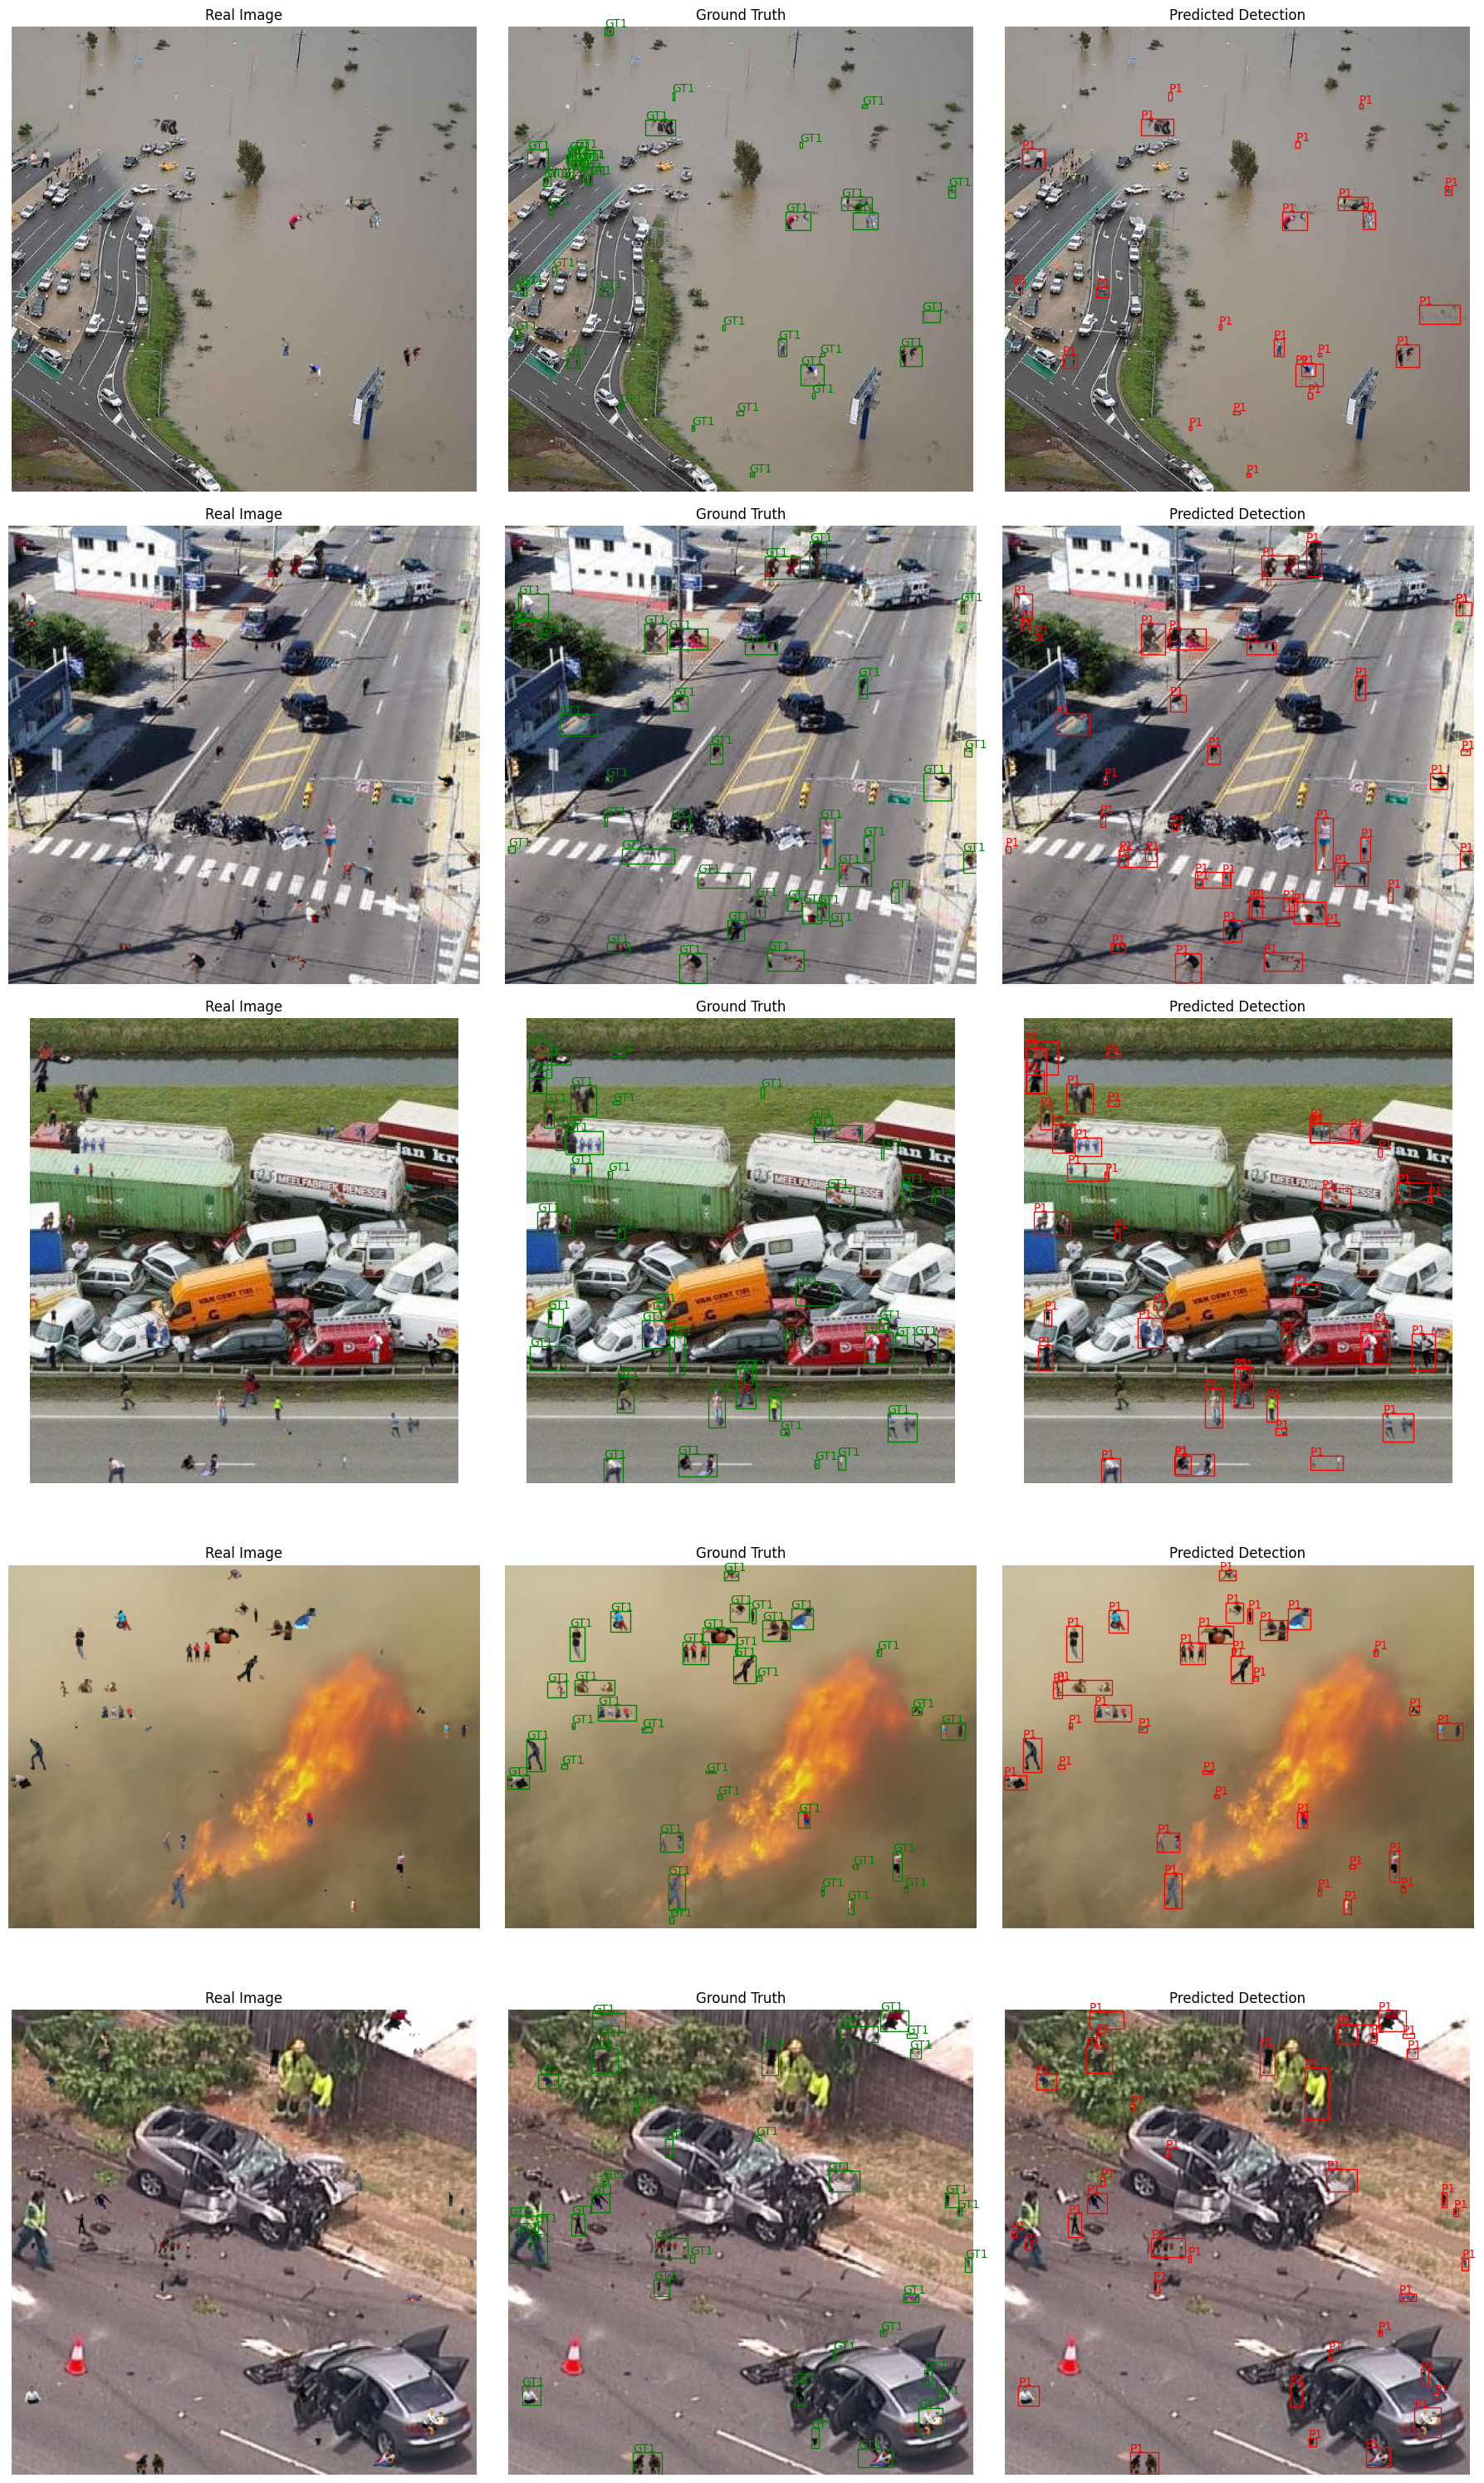

In [13]:
# 7-------------------------------
# Visualization: Display 5 Random Validation Samples
# -------------------------------

import matplotlib.pyplot as plt         # For plotting images and figures.
import matplotlib.patches as patches     # For drawing rectangle patches (bounding boxes).
import numpy as np                       # For numerical operations.

# Set the number of random samples to visualize.
num_vis = 5

# Randomly sample 5 indices from the test_dataset (assumes test_dataset is defined).
indices = random.sample(range(len(test_dataset)), num_vis)

# Create a figure with 5 rows and 3 columns (for 3 panels per sample).
# The figure size is set to 18 inches in width and 6 * num_vis inches in height.
fig, axes = plt.subplots(nrows=num_vis, ncols=3, figsize=(18, 6 * num_vis))

# Define a helper function to draw bounding boxes on an axis.
def draw_boxes(ax, boxes, color, label_prefix):
    for i, box in enumerate(boxes):
        # Unpack the bounding box coordinates.
        x1, y1, x2, y2 = box
        # Calculate the width and height of the box.
        w, h = x2 - x1, y2 - y1
        # Create a rectangle patch with the calculated position and dimensions.
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)  # Add the rectangle patch to the axis.
        # Add a text label (e.g., GT1, GT2, etc. for ground truth or P1, P2, etc. for prediction) near the box.
        ax.text(x1, y1, f"{label_prefix}{i+1}", color=color, fontsize=10, backgroundcolor="none")

# Loop over each randomly selected sample index.
for idx_i, idx in enumerate(indices):
    # Get the image and target annotations from the test_dataset.
    image, target = test_dataset[idx]
    
    # -------------------------------
    # Denormalize the image for visualization.
    # -------------------------------
    # The applied transform normalized the image using ImageNet statistics.
    # To visualize, we reverse that normalization.
    image_np = image.clone()  # Clone the tensor to avoid modifying the original.
    # Multiply by the standard deviation and add the mean to reverse normalization.
    image_np = image_np * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib.
    image_np = image_np.permute(1, 2, 0).cpu().numpy()
    # Clip the values to ensure they are within the [0, 1] range.
    image_np = np.clip(image_np, 0, 1)
    
    # -------------------------------
    # Panel 1: Display the Real Image.
    # -------------------------------
    ax1 = axes[idx_i, 0]
    ax1.imshow(image_np)
    ax1.set_title("Real Image")
    ax1.axis("off")  # Hide axis ticks and labels.
    
    # -------------------------------
    # Panel 2: Display Ground Truth Bounding Boxes.
    # -------------------------------
    ax2 = axes[idx_i, 1]
    ax2.imshow(image_np)
    ax2.set_title("Ground Truth")
    ax2.axis("off")
    # Loop over each ground truth box and draw it in green.
    for box in target["boxes"]:
        draw_boxes(ax2, [box.cpu().numpy()], "g", "GT")
    
    # -------------------------------
    # Panel 3: Display Predicted Detections.
    # -------------------------------
    ax3 = axes[idx_i, 2]
    ax3.imshow(image_np)
    ax3.set_title("Predicted Detection")
    ax3.axis("off")
    # Run the model on the image to get predictions (move image to the correct device).
    with torch.no_grad():
        pred = model([image.to(device)])[0]
    # Filter predictions to keep only those with scores greater than 0.5.
    keep = pred['scores'] > 0.5
    pred_boxes = pred['boxes'][keep]
    # Loop over each predicted box and draw it in red.
    for box in pred_boxes:
        draw_boxes(ax3, [box.cpu().numpy()], "r", "P")
        
# Adjust the layout so that subplots do not overlap.
plt.tight_layout()
# Display the figure.
plt.show()


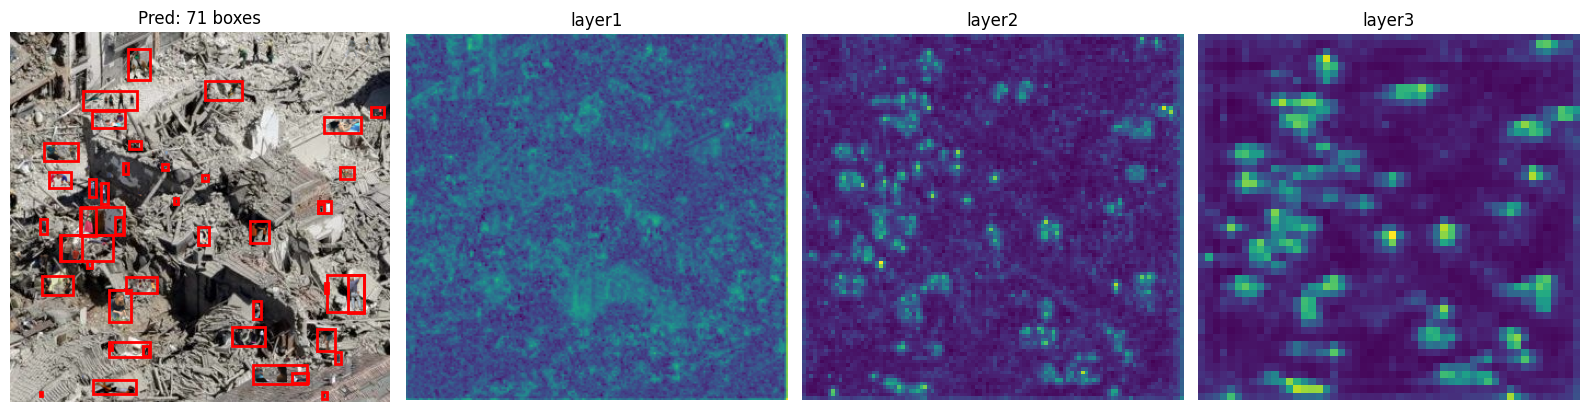

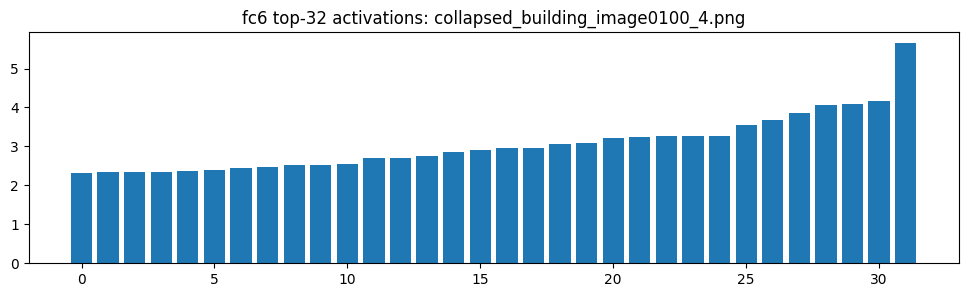

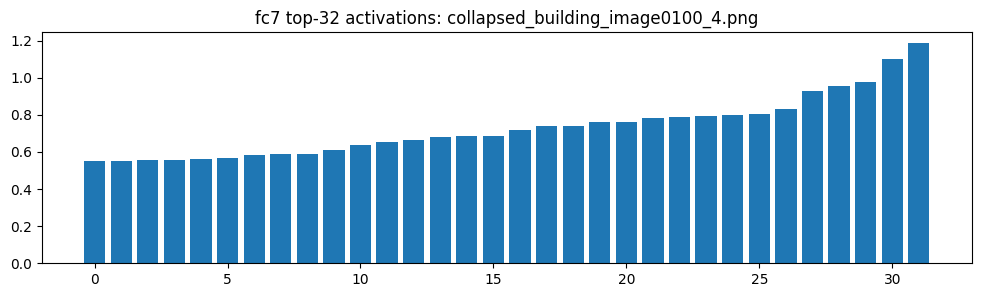

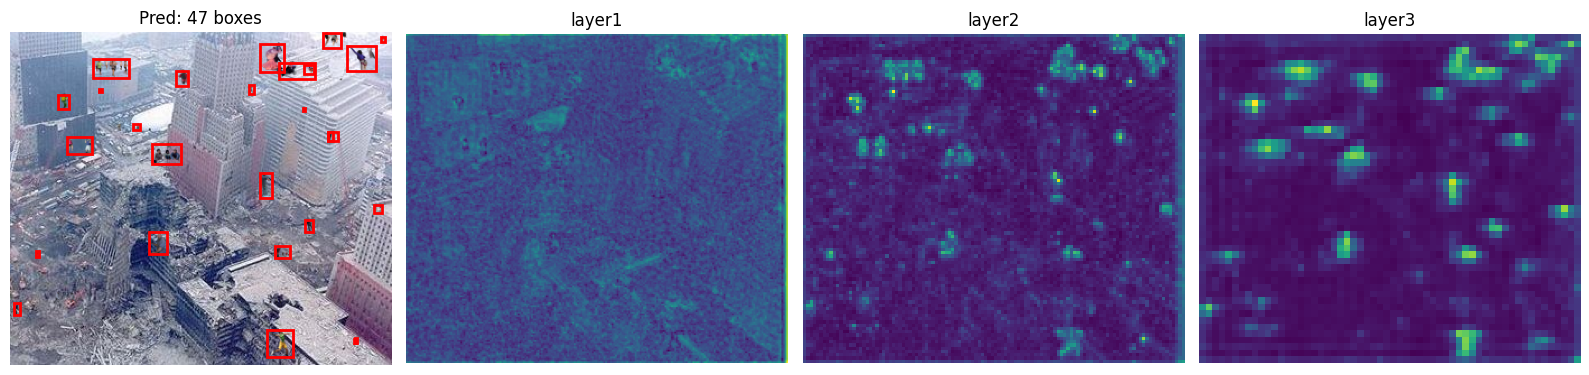

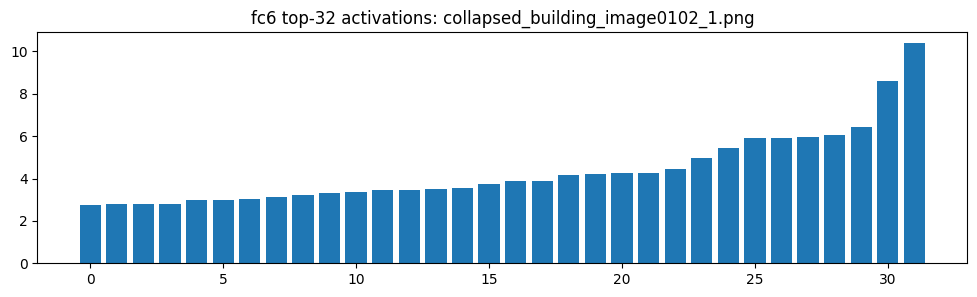

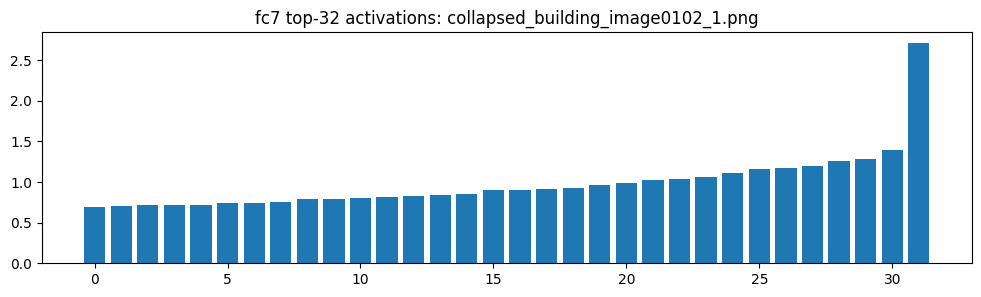

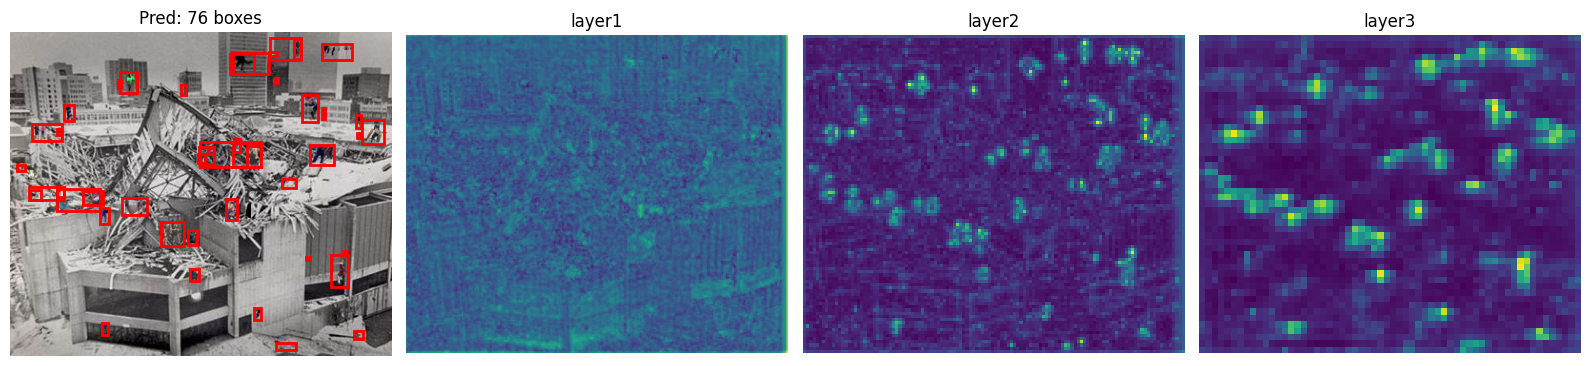

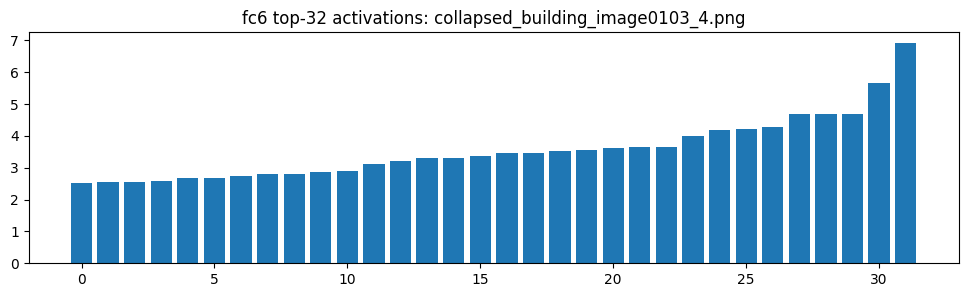

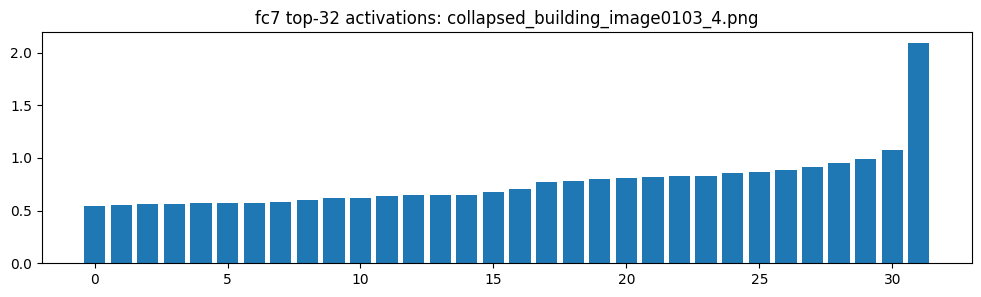

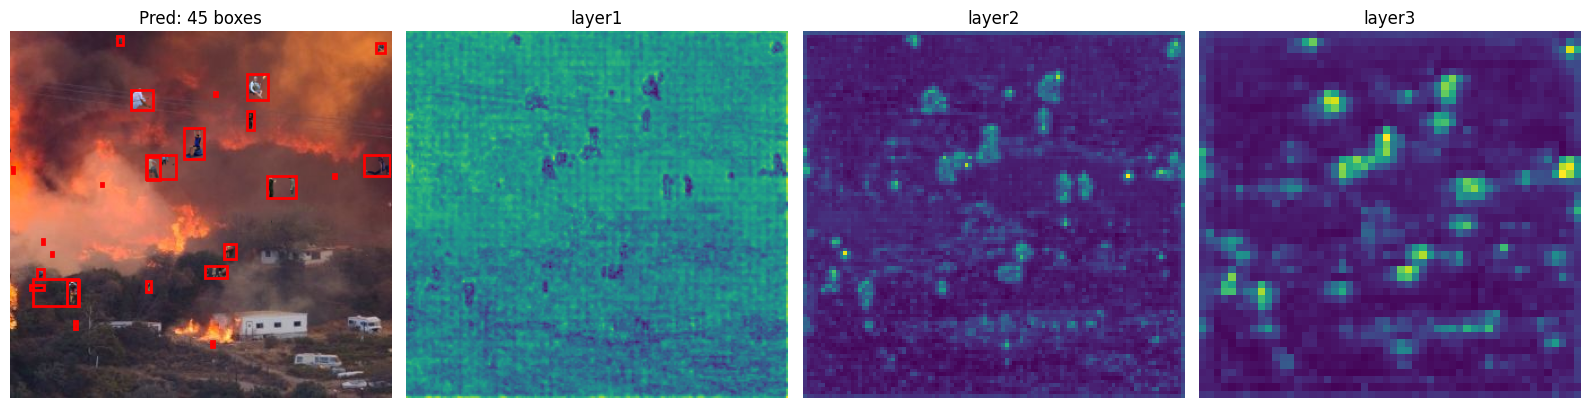

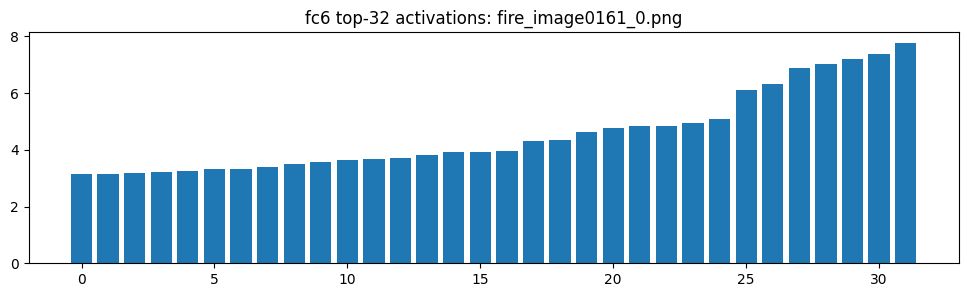

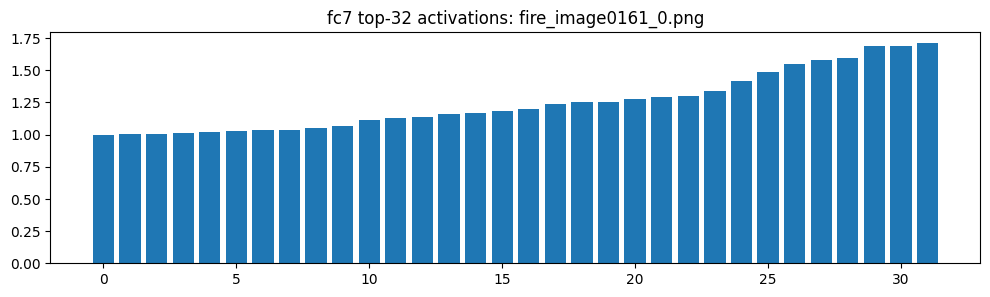

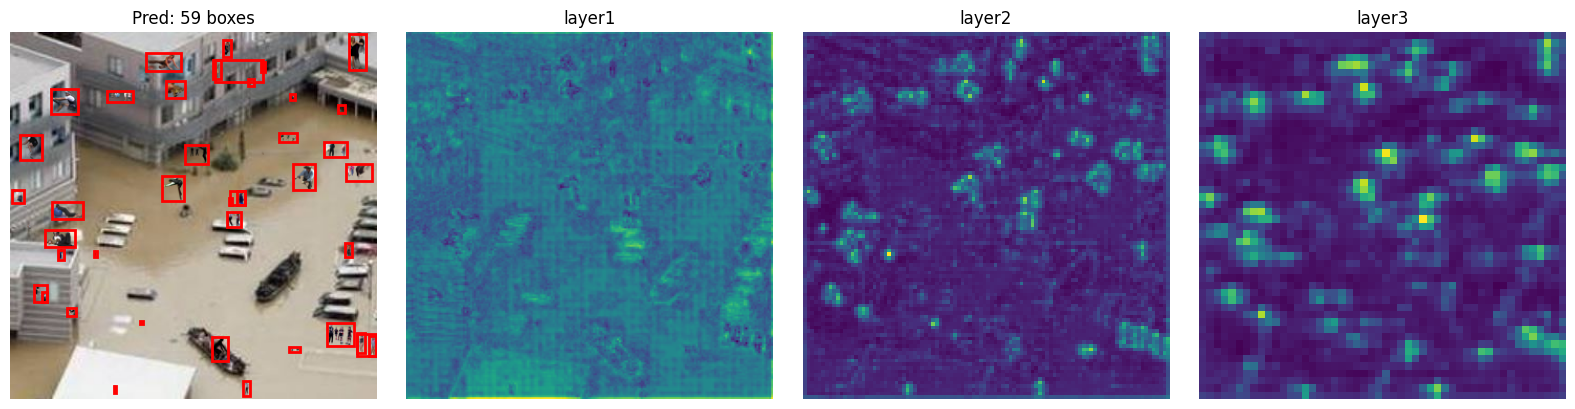

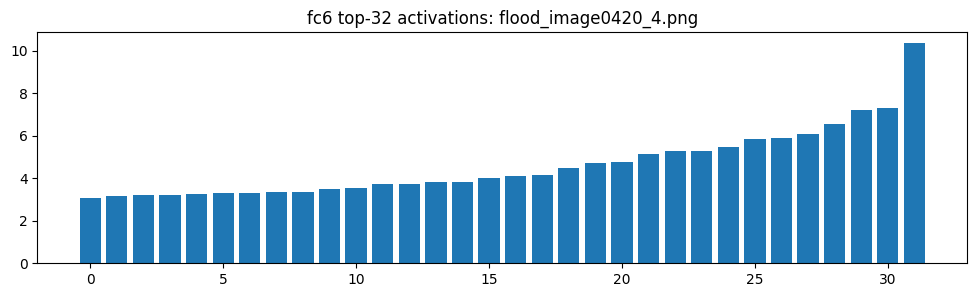

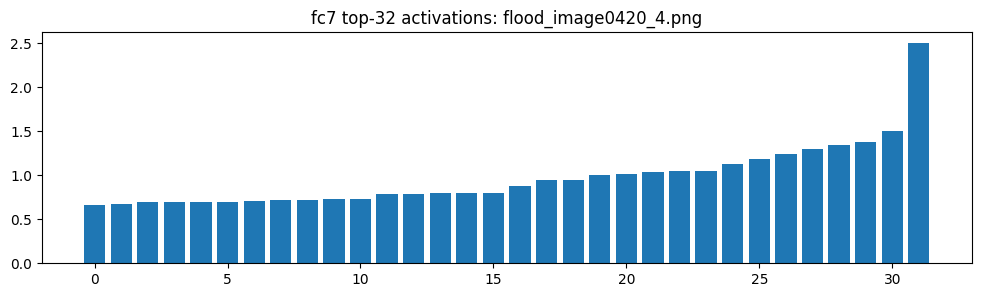

In [14]:
# Visualize feature maps (3 layers) and dense activations (2 layers) for 5 specified images
import matplotlib.pyplot as plt
import torchvision

# Hook storage
feature_maps = {}
dense_acts = {}

# Access backbone layers: for resnet50_fpn, use body.layer1/2/3
body = model.backbone.body

def save_fmap(name):
    def hook(module, inp, out):
        # Save mean over channels to reduce memory
        with torch.no_grad():
            fmap = out
            if isinstance(fmap, (list, tuple)):
                fmap = fmap[0]
            fmap_mean = fmap.detach().cpu().mean(dim=1, keepdim=True)  # [B,1,H,W]
            feature_maps[name] = fmap_mean
    return hook

# FC layers inside ROI heads: use box_head.fc6 and box_head.fc7

def save_dense(name):
    def hook(module, inp, out):
        with torch.no_grad():
            v = out.detach().cpu().flatten(1)  # [B, N]
            dense_acts[name] = v
    return hook

h1 = body.layer1.register_forward_hook(save_fmap('layer1'))
h2 = body.layer2.register_forward_hook(save_fmap('layer2'))
h3 = body.layer3.register_forward_hook(save_fmap('layer3'))
h_fc6 = model.roi_heads.box_head.fc6.register_forward_hook(save_dense('fc6'))
h_fc7 = model.roi_heads.box_head.fc7.register_forward_hook(save_dense('fc7'))

# Select 5 images
selected_dir = './C2A_selected'
selected_files = [
    'collapsed_building_image0100_4.png',
    'collapsed_building_image0102_1.png',
    'collapsed_building_image0103_4.png',
    'fire_image0161_0.png',
    'flood_image0420_4.png',
]

fig_idx = 1
for fname in selected_files:
    path = os.path.join(selected_dir, fname)
    img = Image.open(path).convert('RGB')
    img_t = transforms.ToTensor()(img).to(device)
    model.eval()
    with torch.no_grad():
        pred = model([img_t])[0]
    # Plot predictions overlay
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title(f'Pred: {len(pred["boxes"]) } boxes')
    ax = plt.gca()
    keep = pred['scores'] > 0.3
    for b in pred['boxes'][keep].cpu():
        x1,y1,x2,y2 = b.tolist()
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, color='r', linewidth=2)
        ax.add_patch(rect)
    plt.axis('off')
    # Trigger hooks by running backbone on a batch
    with torch.no_grad():
        _ = model([img_t])
    # Show 3 feature maps (mean over channels)
    for i, layer in enumerate(['layer1','layer2','layer3'], start=2):
        fmap = feature_maps.get(layer)
        if fmap is not None:
            fmap_np = fmap[0,0].numpy()
            plt.subplot(1,4,i)
            plt.imshow(fmap_np, cmap='viridis')
            plt.title(layer)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Dense activations bar plots
    for name in ['fc6','fc7']:
        v = dense_acts.get(name)
        if v is not None:
            v1 = v[0].numpy()
            top_idx = np.argsort(v1)[-32:]
            plt.figure(figsize=(12,3))
            plt.bar(range(32), v1[top_idx])
            plt.title(f'{name} top-32 activations: {fname}')
            plt.show()

# Remove hooks
h1.remove(); h2.remove(); h3.remove(); h_fc6.remove(); h_fc7.remove()

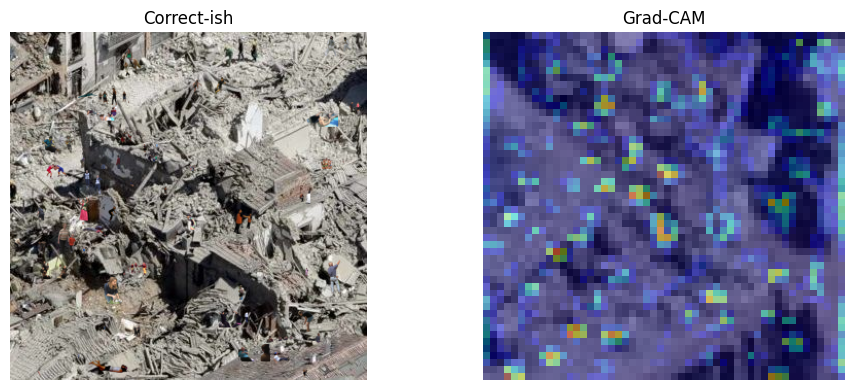

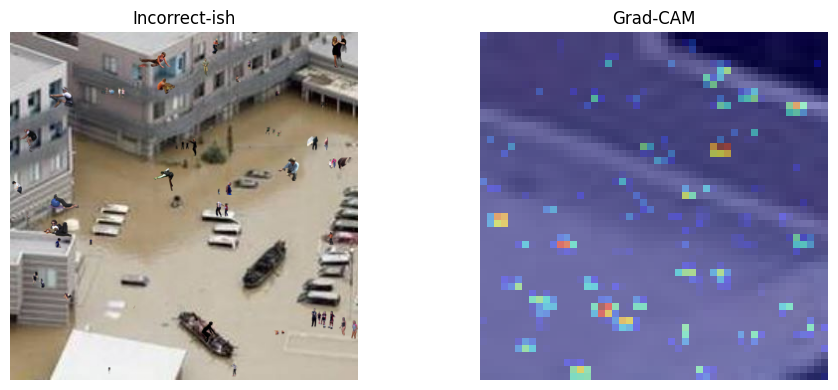

In [15]:
# Grad-CAM for Faster R-CNN backbone (layer3)
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.layer = layer
        self.gradients = None
        self.activations = None
        self.h_forward = layer.register_forward_hook(self._forward_hook)
        self.h_backward = layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, image_t, target_box_idx=0):
        self.model.eval()
        image_t = image_t.to(device)
        image_t.requires_grad_(True)
        outputs = self.model([image_t])[0]
        if len(outputs['scores'])==0:
            return None, outputs
        # Use top-scoring box or specified idx
        idx = target_box_idx if target_box_idx < len(outputs['scores']) else 0
        score = outputs['scores'][idx]
        self.model.zero_grad()
        score.backward(retain_graph=True)
        # Compute weights and heatmap
        grads = self.gradients  # [B,C,H,W]
        acts = self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam[0,0]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        return cam.cpu().numpy(), outputs

# Use backbone body layer3
cam_layer = model.backbone.body.layer3
cam = GradCAM(model, cam_layer)

# Show Grad-CAM for one correct and one incorrect case (heuristic)
import matplotlib.pyplot as plt

def show_cam_on_image(img_pil, cam_map, title):
    img_np = np.array(img_pil).astype(np.float32)/255.0
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.title(title); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img_np); plt.imshow(cam_map, cmap='jet', alpha=0.45); plt.title('Grad-CAM'); plt.axis('off')
    plt.tight_layout(); plt.show()

# Try two images from selected list
selected_dir = './C2A_selected'
correct_img = Image.open(os.path.join(selected_dir, 'collapsed_building_image0100_4.png')).convert('RGB')
wrong_img   = Image.open(os.path.join(selected_dir, 'flood_image0420_4.png')).convert('RGB')

for img_pil, name in [(correct_img, 'Correct-ish'), (wrong_img, 'Incorrect-ish')]:
    img_t = transforms.ToTensor()(img_pil)
    cam_map, out = cam(img_t)
    if cam_map is not None:
        show_cam_on_image(img_pil, cam_map, name)
    else:
        print('No detections for', name)